In [1]:
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd

data = pd.read_csv("NFLX.csv")  # 데이터 파일을 읽어옴
data.head() 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
3,2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
4,2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1007 non-null   object 
 1   Open       1007 non-null   float64
 2   High       1007 non-null   float64
 3   Low        1007 non-null   float64
 4   Close      1007 non-null   float64
 5   Adj Close  1007 non-null   float64
 6   Volume     1007 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.2+ KB


In [5]:
class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv(r'NFLX.csv')
        self.data = self.csv.iloc[:,1:4].values
        self.data = self.data / np.max(self.data)
        self.label = data['Close'].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30

    def __getitem__(self, i):
        data = selef.data[i:i+30]
        label = self.label[i+30]
        return data, label

SyntaxError: invalid syntax (4201943294.py, line 2)

In [4]:
class Netflix(Dataset):  # ❶ 클래스 선언
    def __init__(self):
        self.csv = pd.read_csv(r'NFLX.csv')        # ❷ 데이터 읽기

        # 입력 데이터 정규화
        self.data = self.csv.iloc[:, 1:4].values   # ❸ 종가를 제외한 데이터
        self.data = self.data / np.max(self.data)  # ➍ 0과 1 사이로 정규화

        # ➎ 종가 데이터 정규화
        self.label = data["Close"].values         
        self.label = self.label / np.max(self.label)
    def __len__(self):
        return len(self.data) - 30 # ❶ 사용 가능한 배치 개수

    def __getitem__(self, i):
        data = self.data[i:i+30] # ❶ 입력 데이터 30일치 읽기
        label = self.label[i+30] # ❷ 종가 데이터 30일치 읽기

        return data, label


In [5]:
import torch
import torch.nn as nn

class RNN(nn.Module):
   def __init__(self):
       super(RNN, self).__init__()

       self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5,
                         batch_first=True)  # ❶ RNN층의 정의

       # ❷ 주가를 예측하는 MLP층 정의
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)

       self.relu = nn.ReLU() # 활성화 함수 정의
        
   def forward(self, x, h0):
       x, hn = self.rnn(x, h0)  # ❶ RNN층의 출력

       # ❷ MLP층의 입력으로 사용될 수 있도록 모양 변경
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
      
       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

In [6]:
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델의 정의
dataset = Netflix()  # 데이터셋의 정의

In [7]:
loader = DataLoader(dataset, batch_size=32)  # 배치 크기를 32로 설정
optim = Adam(params=model.parameters(), lr=0.0001) # 사용할 최적화를 설정

In [8]:
for epoch in range(200):
   iterator = tqdm.tqdm(loader)
   for data, label in iterator:
       optim.zero_grad()

       # ❶ 초기 은닉 상태
       h0 = torch.zeros(5, data.shape[0], 8).to(device)

       # ❷ 모델의 예측값
       pred = model(data.type(torch.FloatTensor).to(device), h0)

       # ❸ 손실의 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화 진행

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./rnn.pth")  # 모델 저장

epoch199 loss:0.001801882404834032: 100%|██████████████████████████████████████████████| 31/31 [00:00<00:00, 32.31it/s]


In [9]:


loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  # ➊초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  # ➋예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # ➌손실의 평균치 계산

total_loss.item()

0.004274309612810612

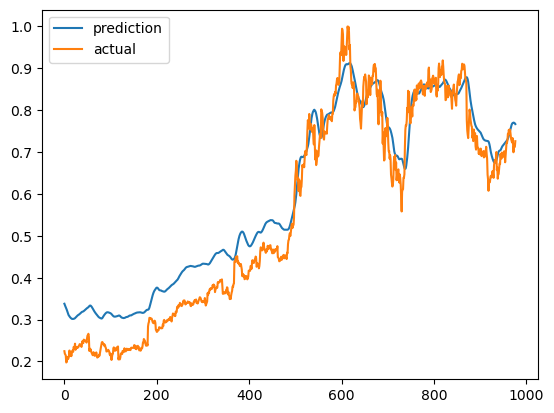

In [10]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()